# Preamble

In [1]:
%%time

import snowflake.snowpark.modin.plugin
import modin.pandas as pd
import numpy as np
import datetime
import pandas as native_pd
from snowflake.snowpark.session import Session; session = Session.builder.create()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://snowbiz.okta.com/app/snowflake/exk8wfsfryJIn4IWZ2p7/sso/saml?SAMLRequest=jVJdc9owEPwrHvUZy3agBA2QoYE0bkgA25CZvAlbEBVZUnVyDP31lfnopA%2FJ9E1z2r3du73%2Bzb4U3hszwJUcoNAPkMdkrgoutwO0zO5a18gDS2VBhZJsgA4M0M2wD7QUmowq%2ByoT9qtiYD3XSAJpPgaoMpIoChyIpCUDYnOSjh6nJPIDQgGYsU4OnSkFcKf1aq0mGNd17ddXvjJbHAVBgIMedqgG8gW9k9Cfa2ijrMqVuFD2bqYPJEIctBsJh3AK8zPxG5enFXymsj6BgNxn2bw1n6UZ8kaX6W6VhKpkJmXmjedsmUxPBsA5SJ9mz%2FezZTrxQap6I%2BiO5arUlXXdfPfCG1Zgobbc7SgeD5De8WL0NS3MpBc%2BxjUcJt8XUfbQo%2BuHadLrLpJ0tV3p9TTRifjZWeTIW10SjZpEY4CKxbLJ0bpSEHVaQbsVhFkUkahLrtp%2BJ4xekDd2OXJJ7ZF5MdtYXPPfvtpZejRHtcZ%2FfWO2313XG9iYw49YtuPnl0h3MYDCTUzodCnkaMAM%2F3f%2BPn7POh%2Fbk9t%2FPJ4rwfODd6dMSe3H8YR%2BeKzworU5QgkrKRejojAMwMUkhKpvDaPW3bQ1FUN4eFL996qHfwA%3D&RelayState=ver%3A1-hint

# Use case 1: working with a single small table

In this example, we read the Snowhouse table `SAMPLE_DATA.TPCH_SF1.CUSTOMER`, which is 150k rows and 10.3 MB in Snowflake.

In [2]:
%%time

df = pd.read_snowflake("SAMPLE_DATA.TPCH_SF1.CUSTOMER")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_4BHELI4ZHP' for snapshotting. DataFrame creation might take some time.


CPU times: user 88.5 ms, sys: 37.9 ms, total: 126 ms
Wall time: 4.3 s


Just printing the data is visibly slow...

In [3]:
df

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra
...,...,...,...,...,...,...,...,...
149995,29996,Customer#000029996,BnZVGZiAgcEImNm9iD,7,17-536-308-8025,4035.17,FURNITURE,"ual instructions. bold, silent foxes nag blith..."
149996,29997,Customer#000029997,lTbDYXdQ74JctD UbRbXCqF2b8,9,19-631-777-4123,2015.90,HOUSEHOLD,eodolites detect slyly alongside of the quickl...
149997,29998,Customer#000029998,ZxxiuDruzi98CcymR,23,33-619-315-9722,-810.56,FURNITURE,xpress packages. accounts sleep carefully iron...
149998,29999,Customer#000029999,CuPA4UpgTCYiXrBrpiSO D,12,22-824-951-8333,3865.14,FURNITURE,eposits-- accounts haggle across the slyly per...


and doing certain complex transformations is very slow.

In [4]:
%%time

result = df.groupby('C_NATIONKEY').apply(lambda group: group.C_CUSTKEY.iloc[0] + group.C_CUSTKEY.mean())

KeyboardInterrupt: 

## Let's switch the backend to python!

We pay a one-time cost of a few seconds to load the data into memory.

In [5]:
%%time

df = df.move_to('Pandas')

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 799 ms, sys: 157 ms, total: 956 ms
Wall time: 3.34 s


But now printing is extremely fast...

In [6]:
type(df.dtypes)

pandas.core.series.Series

In [7]:
df

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra
...,...,...,...,...,...,...,...,...
149995,29996,Customer#000029996,BnZVGZiAgcEImNm9iD,7,17-536-308-8025,4035.17,FURNITURE,"ual instructions. bold, silent foxes nag blith..."
149996,29997,Customer#000029997,lTbDYXdQ74JctD UbRbXCqF2b8,9,19-631-777-4123,2015.90,HOUSEHOLD,eodolites detect slyly alongside of the quickl...
149997,29998,Customer#000029998,ZxxiuDruzi98CcymR,23,33-619-315-9722,-810.56,FURNITURE,xpress packages. accounts sleep carefully iron...
149998,29999,Customer#000029999,CuPA4UpgTCYiXrBrpiSO D,12,22-824-951-8333,3865.14,FURNITURE,eposits-- accounts haggle across the slyly per...


And so are most things we can imagine doing with the data.

In [8]:
%%time

result = df.groupby('C_NATIONKEY').apply(lambda group: group.C_CUSTKEY.iloc[0] + group.C_CUSTKEY.mean())
print(result)

C_NATIONKEY
0     104809.648945
1     104849.461925
2     105879.897816
3     104446.823588
4     104679.314262
5     104906.427251
6     105917.388361
7     104694.312288
8     105173.743462
9     105037.669210
10    105448.956232
11    104112.225725
12    104829.006557
13    106009.666832
14    104419.615654
15    105264.778247
16    104199.408269
17    105125.565188
18    104305.006972
19    105746.410656
20    104615.581809
21    105924.703395
22    105530.506581
23    105457.153718
24    104223.723884
dtype: float64
CPU times: user 54.4 ms, sys: 7.43 ms, total: 61.8 ms
Wall time: 59.7 ms


When we're done with our transformations, we can write the results to Snowflake.

In [10]:
%%time

snow_result = result.rename('result').move_to('Snowflake')

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 29.6 ms, sys: 7.31 ms, total: 36.9 ms
Wall time: 767 ms


In [11]:
%%time

snow_result.to_snowflake('TEMP.MVASHISHTHA.RESULT', if_exists='replace', index=False)

CPU times: user 20.9 ms, sys: 7.17 ms, total: 28.1 ms
Wall time: 826 ms


# Use case 2: Filtering out most of a large table, then using python

## Setup

In this example, we read the table `SAMPLE_DATA.TPCH_SF10.LINEITEM`, which is 60M rows and 1.3 GB.

In [12]:
%%time

df = pd.read_snowflake("SAMPLE_DATA.TPCH_SF10.LINEITEM")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF10.LINEITEM' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF10.LINEITEM' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_AQQ1QVOKYK' for snapshotting. DataFrame creation might take some time.


CPU times: user 70.4 ms, sys: 24.5 ms, total: 94.9 ms
Wall time: 10.2 s


The data is large, and pulling it all into pandas would take about 2.5 minutes...

In [18]:
#df.set_backend('Pandas')

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

,L_ORDERKEY,L_PARTKEY,L_SUPPKEY,L_LINENUMBER,L_QUANTITY,L_EXTENDEDPRICE,L_DISCOUNT,L_TAX,L_RETURNFLAG,L_LINESTATUS,L_SHIPDATE,L_COMMITDATE,L_RECEIPTDATE,L_SHIPINSTRUCT,L_SHIPMODE,L_COMMENT
0,56224388,804093,54110,2,5.0,4985.25,0.04,0.08,N,O,1998-04-25,1998-05-30,1998-05-24,COLLECT COD,MAIL,inst the exp
1,56224388,387466,87467,3,13.0,20194.85,0.04,0.04,N,O,1998-03-29,1998-04-15,1998-04-12,DELIVER IN PERSON,REG AIR,"e regular, spe"
2,56224388,127861,27862,4,26.0,49110.36,0.09,0.02,N,O,1998-05-14,1998-05-25,1998-06-06,TAKE BACK RETURN,MAIL,ve the final ideas cajole slyly
3,56224388,955237,55238,5,38.0,49103.22,0.10,0.01,N,O,1998-03-08,1998-04-19,1998-03-25,NONE,AIR,sts sleep around the slow
4,56224389,16386,41387,1,26.0,33861.88,0.04,0.00,A,F,1995-05-17,1995-06-14,1995-05-18,COLLECT COD,MAIL,ideas. slyly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59986047,59974884,889130,39147,3,24.0,26858.16,0.03,0.06,R,F,1993-01-10,1993-02-24,1993-01-18,DELIVER IN PERSON,RAIL,the carefully express fo
59986048,59974884,1596930,71976,4,3.0,6080.58,0.08,0.08,R,F,1993-02-14,1993-02-17,1993-03-15,COLLECT COD,AIR,ove the regularly ironic
59986049,59974884,1588342,13358,5,46.0,65792.42,0.08,0.06,R,F,1993-03-21,1993-03-04,1993-04-06,DELIVER IN PERSON,TRUCK,onic requests sleep acco
59986050,59974884,1249071,24108,6,44.0,44880.44,0.09,0.04,A,F,1993-02-07,1993-02-17,1993-02-20,DELIVER IN PERSON,TRUCK,about the ideas. bold


But we only need to work with a sample of the data, so we sample 2% of the data.

In [13]:
%%time

filtered = df.sample(frac=0.02)

CPU times: user 76.4 ms, sys: 15.9 ms, total: 92.3 ms
Wall time: 4.18 s


Now it's easier to fetch the data.

In [15]:
%%time

python_filtered = filtered.move_to('PANDAS')

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 2.36 s, sys: 396 ms, total: 2.75 s
Wall time: 4.93 s


Now we can do a complex operation on the filtered subset of the data.

In [16]:
%%time

python_filtered.groupby('L_SHIPMODE').apply(lambda group: group.L_ORDERKEY.iloc[0] + group.L_ORDERKEY.mean())

CPU times: user 254 ms, sys: 31.8 ms, total: 285 ms
Wall time: 283 ms


L_SHIPMODE
AIR        4.314149e+07
FOB        4.319355e+07
MAIL       4.317048e+07
RAIL       4.314031e+07
REG AIR    4.316588e+07
SHIP       4.321064e+07
TRUCK      4.317835e+07
dtype: float64

Doing the same operation on the filtered data in Snowflake would take much longer.

In [17]:
%%time

filtered.groupby('L_SHIPMODE').apply(lambda group: group.L_ORDERKEY.iloc[0] + group.L_ORDERKEY.mean())

KeyboardInterrupt: 

In [27]:
# Use case 3: Intermingling engines

In [2]:
snow_df = pd.read_snowflake("SAMPLE_DATA.TPCH_SF10.LINEITEM")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF10.LINEITEM' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF10.LINEITEM' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_2YYUP5L6KH' for snapshotting. DataFrame creation might take some time.


In [3]:
%%time

native_df = snow_df['L_SHIPMODE'].value_counts().move_to('Pandas')
native_df

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 212 ms, sys: 84.8 ms, total: 297 ms
Wall time: 1.5 s


L_SHIPMODE
RAIL       8571844
SHIP       8571402
REG AIR    8570280
FOB        8569760
MAIL       8569053
TRUCK      8567549
AIR        8566164
Name: count, dtype: int64

In [7]:
snow_df.columns

Index(['L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER', 'L_QUANTITY',
       'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX', 'L_RETURNFLAG',
       'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE', 'L_RECEIPTDATE',
       'L_SHIPINSTRUCT', 'L_SHIPMODE', 'L_COMMENT'],
      dtype='object')

In [12]:
snow_df.get_backend()

'Snowflake'

In [9]:
native_df

L_SHIPMODE
RAIL       8571844
SHIP       8571402
REG AIR    8570280
FOB        8569760
MAIL       8569053
TRUCK      8567549
AIR        8566164
Name: count, dtype: int64

In [10]:
snow_df.merge(native_df, on="L_SHIPMODE")

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

,L_ORDERKEY,L_PARTKEY,L_SUPPKEY,L_LINENUMBER,L_QUANTITY,L_EXTENDEDPRICE,L_DISCOUNT,L_TAX,L_RETURNFLAG,L_LINESTATUS,L_SHIPDATE,L_COMMITDATE,L_RECEIPTDATE,L_SHIPINSTRUCT,L_SHIPMODE,L_COMMENT,count
0,27517350,1896835,71890,5,42.0,76933.08,0.08,0.08,R,F,1992-10-31,1992-10-17,1992-11-30,DELIVER IN PERSON,FOB,oxes unwind,8569760
1,27517351,665715,65716,1,22.0,36974.96,0.08,0.08,N,O,1997-03-15,1997-01-13,1997-03-18,COLLECT COD,AIR,e across the bli,8566164
2,27517351,666667,16680,2,39.0,63711.57,0.09,0.03,N,O,1997-04-11,1997-01-22,1997-04-24,COLLECT COD,TRUCK,beans sleep care,8567549
3,27517351,671029,71030,3,2.0,1999.98,0.03,0.06,N,O,1997-02-27,1997-02-18,1997-03-12,DELIVER IN PERSON,SHIP,ual theodolites. careful,8571402
4,27517351,1977061,2081,4,2.0,2275.94,0.07,0.01,N,O,1997-03-13,1997-02-21,1997-04-06,NONE,RAIL,uickly along th,8571844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59986047,19721668,1258271,33308,1,15.0,18438.15,0.01,0.04,N,O,1995-09-02,1995-07-14,1995-09-16,DELIVER IN PERSON,SHIP,l foxes detect carefully. slyly r,8571402
59986048,19721668,1753262,3297,2,38.0,49976.84,0.02,0.00,N,O,1995-07-17,1995-08-26,1995-08-15,NONE,RAIL,ly final pa,8571844
59986049,19721669,124306,24307,1,28.0,37248.40,0.02,0.08,A,F,1992-09-30,1992-09-21,1992-10-01,TAKE BACK RETURN,MAIL,ole carefully slyly final deposits. ca,8569053
59986050,19721669,1194302,44325,2,36.0,50265.00,0.03,0.04,R,F,1992-10-24,1992-08-26,1992-10-25,TAKE BACK RETURN,TRUCK,theodolites,8567549


In [8]:
snow_df.dtypes

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://snowbiz.okta.com/app/snowflake/exk8wfsfryJIn4IWZ2p7/sso/saml?SAMLRequest=jVJdc9owEPwrHvXZlgykIRogQ0MozpBAMJApb8KWQUGWXJ0cQ399ZT4y6UMyfdOcdm%2F3bq9zu8%2Bl98YNCK26KAwI8rhKdCrUposW86HfRh5YplImteJddOCAbnsdYLksaL%2B0WzXjv0sO1nONFND6o4tKo6hmIIAqlnOgNqFx%2F3FMGwGhDIAb6%2BTQmZKCcFpbawuKcVVVQdUMtNngBiEEkxvsUDXkG%2FogUXytURhtdaLlhbJ3M30iEWLSqiUcwilMz8QfQp1W8JXK%2BgQCOprPp%2F50Es%2BR179Md6cVlDk3MTdvIuGL2fhkAJyD%2BGnyMpos4vsAlK4yyXY80XlRWtctcC%2Bc8RRLvRFuR9Ggi4qdSAd2uFTL3LD16iEO5fS%2BPRPZ6%2Ffxq9iS9fO%2Btbnu%2F1yLKh4dfiXIW14SbdSJRgAlj1Sdo3Ul0rjySdNvhvPwhl6FNAyDNiEr5A1cjkIxe2RezNYW1%2BJPoHeWHc2xosDvvjHf79pVBpk5PESqFb2sGsU1BtC4jgmdLoUeDZje%2F87fwR9Z52N7cvuPBlMtRXLwhtrkzH4eTxiEx4pI%2FewIpTxnQvbT1HAAF5OUuroznFl309aUHOHeSfXfq%2B79BQ%3D%3D&RelayState=

SnowparkSQLException: (1304): 01bb61e7-080f-702e-0001-dd47a26ef3df: 002003 (42S02): SQL compilation error:
Object 'SNOWPARK_TEMP_TABLE_AVZFAMGLDDREADONLY' does not exist or not authorized.

In [9]:
native_df.dtypes

dtype('int64')

# Move on read

In [1]:
%%time

import snowflake.snowpark.modin.plugin
import modin.pandas as pd
import numpy as np
import datetime
import pandas as native_pd
from snowflake.snowpark.session import Session; session = Session.builder.create()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://snowbiz.okta.com/app/snowflake/exk8wfsfryJIn4IWZ2p7/sso/saml?SAMLRequest=jVJdc9owEPwrHvUZSzbkSwNkHGgGNwRTbEInb8KWiQZbcnUyhvz6ynx00odk%2BqY57d7u3V7%2Ffl8Wzo5rEEoOkOcS5HCZqkzIzQAtk8fOLXLAMJmxQkk%2BQAcO6H7YB1YWFQ1q8yYX%2FHfNwTi2kQTafgxQrSVVDARQyUoO1KQ0Dp6n1HcJZQBcGyuHzpQMhNV6M6aiGDdN4zZdV%2BkN9gkhmNxhi2oh39AHieprjUoro1JVXCh7O9MnEh4mvVbCIqzC%2FEx8EPK0gq9U1icQ0EmSzDvzKE6QE1ymGykJdcl1zPVOpHy5mJ4MgHUQz6LVJFrG312QqskLtuWpKqva2G6ufeGcZ7hQG2F3FI4HqNqKbP0if04nlYanRbKJ3kdrFv16ejjsVj1yd9jl8Yz7QbCYR1xtU%2BS8XBL120RDgJqHss3R2BLxrzqk1yF%2B4t1Qck2veu51t%2FuKnLHNUUhmjsyL2dbiWry7amvY0RyrKvzXN%2Bb77W2TQ64PP0LZC1evfnWDARRuY0KnS6FHA3r4v%2FP38UfW%2Bdhmdv%2FheK4KkR6cR6VLZj6Px3O9Y0VknfwIpbxkogiyTHMAG1NRqGakOTP2po2uOcLDk%2Bq%2FVz38Aw%3D%3D&RelayState=ver%3A1-

In [2]:
df = pd.read_snowflake("SAMPLE_DATA.TPCH_SF1.CUSTOMER")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_Q1N3FXVBRG' for snapshotting. DataFrame creation might take some time.


Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df.get_backend()

'Pandas'

In [4]:
df

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra
...,...,...,...,...,...,...,...,...
149995,29996,Customer#000029996,BnZVGZiAgcEImNm9iD,7,17-536-308-8025,4035.17,FURNITURE,"ual instructions. bold, silent foxes nag blith..."
149996,29997,Customer#000029997,lTbDYXdQ74JctD UbRbXCqF2b8,9,19-631-777-4123,2015.90,HOUSEHOLD,eodolites detect slyly alongside of the quickl...
149997,29998,Customer#000029998,ZxxiuDruzi98CcymR,23,33-619-315-9722,-810.56,FURNITURE,xpress packages. accounts sleep carefully iron...
149998,29999,Customer#000029999,CuPA4UpgTCYiXrBrpiSO D,12,22-824-951-8333,3865.14,FURNITURE,eposits-- accounts haggle across the slyly per...


In [5]:
df_big = pd.read_snowflake("SAMPLE_DATA.TPCH_SF10.CUSTOMER")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF10.CUSTOMER' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF10.CUSTOMER' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_BCG1A32YWB' for snapshotting. DataFrame creation might take some time.


In [6]:
df_big.get_backend()

'Snowflake'

## In Memory Uses Local

In [4]:
df = pd.DataFrame({'a': [1], 'b': [2]})

In [5]:
df.get_backend()

'Pandas'

## Apply Switches using Rules

In [1]:
import snowflake.snowpark.modin.plugin
import modin.pandas as pd
import numpy as np
import datetime
import pandas as native_pd
from snowflake.snowpark.session import Session; session = Session.builder.create()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://snowbiz.okta.com/app/snowflake/exk8wfsfryJIn4IWZ2p7/sso/saml?SAMLRequest=jZLdbuIwEIVfJfJeJ04C%2FcECqiwUEUQLJVAq7tzEUBfHznocAvv064Sy6l602jtrfI79zZzp3h1z4RyYBq5kDwWejxwmU5Vxueuh1XLk3iIHDJUZFUqyHjoxQHf9LtBcFCQqzZtcsF8lA%2BPYhySQ5qKHSi2JosCBSJozICYlSfQwJaHnk0Iro1Il0CfL9w4KwLSxhBdLBtzivRlTEIyrqvKqlqf0Doe%2B72O%2Fg62qlvy46I%2B2py%2F0Afbbtd4qrHz%2BwfaTy%2FMIvsN6PYuAjJfLuTufJUvkRBfUgZJQ5kwnTB94ylaL6RkALEHyOFuPZ6vk3gOpqq2ge5aqvCiNfc2zJ7xlGRZqx23D8bCHij3PxNNh2urcF8HoRbSyKN9MZuJ5zUdPD4PJaajGLzP9nr8fskWwSpHzfEk0rBONAUoWyzpHY0t%2BeOX6bdcPl8ENCTskvPI619cb5AxtjlxS0zgvsDXiK%2F%2Ftqb2hDRwtCvyXG7Pj%2FrbawlafJrFsx%2BtNWNxgAIXrWNF5U0gDoPv%2F238Xf3Z9LNujnX88nCvB05MzUjqn5ut4Ai9oKjxzt42UsJxyEWWZZgA2JiFUNdCMGrvTRpcM4f7513%2B3uv8H&RelayState=ver%3A1-hint%3A2

In [2]:
df_small = pd.read_snowflake("SAMPLE_DATA.TPCH_SF1.CUSTOMER")

Snapshot source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' failed due to reason: `003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_A54PZK0QPN' for snapshotting. DataFrame creation might take some time.


Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df_small.move_to("Snowflake", inplace=True)

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
df_small.get_backend()

'Snowflake'

In [5]:
df_small['C_NAME_NEW'] = df_small['C_NAME'].apply(lambda x: x + " coffee")

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
df_small.get_backend()

'Snowflake'

In [7]:
df_small

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT,C_NAME_NEW
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote,Customer#000030001 coffee
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...,Customer#000030002 coffee
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...,Customer#000030003 coffee
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req,Customer#000030004 coffee
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra,Customer#000030005 coffee
...,...,...,...,...,...,...,...,...,...
149995,29996,Customer#000029996,BnZVGZiAgcEImNm9iD,7,17-536-308-8025,4035.17,FURNITURE,"ual instructions. bold, silent foxes nag blith...",Customer#000029996 coffee
149996,29997,Customer#000029997,lTbDYXdQ74JctD UbRbXCqF2b8,9,19-631-777-4123,2015.90,HOUSEHOLD,eodolites detect slyly alongside of the quickl...,Customer#000029997 coffee
149997,29998,Customer#000029998,ZxxiuDruzi98CcymR,23,33-619-315-9722,-810.56,FURNITURE,xpress packages. accounts sleep carefully iron...,Customer#000029998 coffee
149998,29999,Customer#000029999,CuPA4UpgTCYiXrBrpiSO D,12,22-824-951-8333,3865.14,FURNITURE,eposits-- accounts haggle across the slyly per...,Customer#000029999 coffee


In [8]:
mylocaldf = df_small['C_NAME'].apply(lambda x: x + " coffee2")

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
mylocaldf.get_backend()

'Pandas'

In [10]:
mylocaldf

0         Customer#000030001 coffee2
1         Customer#000030002 coffee2
2         Customer#000030003 coffee2
3         Customer#000030004 coffee2
4         Customer#000030005 coffee2
                     ...            
149995    Customer#000029996 coffee2
149996    Customer#000029997 coffee2
149997    Customer#000029998 coffee2
149998    Customer#000029999 coffee2
149999    Customer#000030000 coffee2
Name: C_NAME, Length: 150000, dtype: object

In [11]:
import logging; logging.getLogger("snowflake.snowpark").setLevel(logging.DEBUG)
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).addFilter(lambda record: "The Snowpark DataFrame in DataFrameReference with id=" not in record.getMessage())
logging.basicConfig()

In [12]:
df_small['C_NAME'].apply(lambda x: x + " coffee3")

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca1-080f-7b4b-0001-dd47ca56274f]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_RESZT8N238("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_RESZT8N238("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca1-080f-776f-0001-dd47ca57c0f7]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_8HVJYJOBAR("__index__" BIGINT, "C_NAME" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.ser

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca1-080f-7b05-0001-dd47ca553df3]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_OHRQTM31WO("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_OHRQTM31WO("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca2-080f-7b4b-0001-dd47ca59e123]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_PZQ7Z1H382("__index__" BIGINT, "C_NAME" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.ser

0         Customer#000030001 coffee3
1         Customer#000030002 coffee3
2         Customer#000030003 coffee3
3         Customer#000030004 coffee3
4         Customer#000030005 coffee3
                     ...            
149995    Customer#000029996 coffee3
149996    Customer#000029997 coffee3
149997    Customer#000029998 coffee3
149998    Customer#000029999 coffee3
149999    Customer#000030000 coffee3
Name: C_NAME, Length: 150000, dtype: object

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca5-080f-77b7-0001-dd47ca63f327]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_SPAC0BCX0E("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_SPAC0BCX0E("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ca5-080f-7aa8-0001-dd47ca64351b]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_F794VAWEUH("__index__" BIGINT, "C_NAME" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.ser

,C_CUSTKEY,C_NAME,C_ADDRESS,C_NATIONKEY,C_PHONE,C_ACCTBAL,C_MKTSEGMENT,C_COMMENT,C_NAME_NEW
0,30001,Customer#000030001,"Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst",4,14-526-204-4500,8848.47,MACHINERY,frays wake blithely enticingly ironic asymptote,Customer#000030001 coffee
1,30002,Customer#000030002,UVBoMtILkQu1J3v,11,21-340-653-9800,5221.81,MACHINERY,he slyly ironic pinto beans wake slyly above t...,Customer#000030002 coffee
2,30003,Customer#000030003,CuGi9fwKn8JdR,21,31-757-493-7525,3014.89,BUILDING,e furiously alongside of the requests. evenly ...,Customer#000030003 coffee
3,30004,Customer#000030004,tkR93ReOnf9zYeO,23,33-870-136-4375,3308.55,AUTOMOBILE,ssly bold deposits. final req,Customer#000030004 coffee
4,30005,Customer#000030005,pvq4uDoD8pEwpAE01aesCtbD9WU8qmlsvoFav5,9,19-144-468-5416,-278.54,MACHINERY,ructions behind the pinto beans x-ra,Customer#000030005 coffee
...,...,...,...,...,...,...,...,...,...
149995,29996,Customer#000029996,BnZVGZiAgcEImNm9iD,7,17-536-308-8025,4035.17,FURNITURE,"ual instructions. bold, silent foxes nag blith...",Customer#000029996 coffee
149996,29997,Customer#000029997,lTbDYXdQ74JctD UbRbXCqF2b8,9,19-631-777-4123,2015.90,HOUSEHOLD,eodolites detect slyly alongside of the quickl...,Customer#000029997 coffee
149997,29998,Customer#000029998,ZxxiuDruzi98CcymR,23,33-619-315-9722,-810.56,FURNITURE,xpress packages. accounts sleep carefully iron...,Customer#000029998 coffee
149998,29999,Customer#000029999,CuPA4UpgTCYiXrBrpiSO D,12,22-824-951-8333,3865.14,FURNITURE,eposits-- accounts haggle across the slyly per...,Customer#000029999 coffee


## describe 

In [1]:
import snowflake.snowpark.modin.plugin
import modin.pandas as pd
import numpy as np
import datetime
import pandas as native_pd
from snowflake.snowpark.session import Session; session = Session.builder.create()
import logging; logging.getLogger("snowflake.snowpark").setLevel(logging.DEBUG)
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).addFilter(lambda record: "The Snowpark DataFrame in DataFrameReference with id=" not in record.getMessage())
logging.basicConfig()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://snowbiz.okta.com/app/snowflake/exk8wfsfryJIn4IWZ2p7/sso/saml?SAMLRequest=jZJBc5swEIX%2FCqOeQUBIbWtsZ%2By4HlMnthvjpJObDIJoDBLVioD76ytw6KSHZHrTrN6Tvt2345umyK1XpoBLMUGe4yKLiVgmXGQTdIiW9hBZoKlIaC4Fm6AzA3QzHQMt8pLMKv0iHtivioG2zEMCSHcxQZUSRFLgQAQtGBAdk%2F3s%2Fo74jktKJbWMZY7eWT53UACmtCHsLQlwg%2FeidUkwruvaqa8cqTLsu66L3RE2qlbypdc3pqcP9B52g1ZvFEa%2Be2Obc3EZwWdYx4sIyCqKdvZuu4%2BQNetRb6WAqmBqz9Qrj9nh4e4CAIZgv9k%2BrbaH%2FTcHhKzTnJ5YLIuy0uY1x5xwyhKcy4ybhsPFBJUnnoTrAT8Kmc43WXP%2FSA%2FX4vhzXWfD4DgPRs0Pbz1YfL3aDlbLKI6R9dgn6reJhgAVC0WbozYl17%2B23cB2%2FcgbksAjnu8Mg9EzshYmRy6o7pw9bIt45L8dedK0g6Nlif9yY9achnUKqTp%2FD0UQPj375QADSNzGii6bQjoANf3f%2Fsf4vett2TZm%2FuFiJ3Men62lVAXVH8fjOV5X4YmddlLCCsrzWZIoBmBiynNZ3ypGtdlprSqG8PTy679bPf0D&RelayState=ver%3A1-hint%3

In [2]:
df_small = pd.read_snowflake("SAMPLE_DATA.TPCH_SF1.CUSTOMER")

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce1-080f-7aa8-0001-dd47cb52c0d7] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce1-080f-7b4b-0001-dd47cb503f17] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION
DEBUG:snowflake.snowpark.modin.plugin._internal.utils:Failed to create read only table for SAMPLE_DATA.TPCH_SF1.CUSTOMER: (1304): 01bb6ce1-080f-7b05-0001-dd47cb51492b: 003029 (0A000): SQL compilation error:
Cannot clone from a table that was imported from a share.
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce1-080f-77b7-0001-dd47cb51e5ef] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION
Cannot clone from a table that was imported from a share.'. Data from source table/view 'SAMPLE_DATA.TPCH_SF1.CUSTOMER' is being copied into a new temporary table 'SNOWPARK_TEMP_TABLE_PQ4CX4S12F'

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce1-080f-7b05-0001-dd47cb514b73]  SELECT "__row_position__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT" FROM ( SELECT "__row_position__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", count(1) OVER (  ) AS "__row_count__" FROM (SELECT METADATA$ROW_POSITION as "__row_position__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT" FROM SNOWPARK_TEMP_TABLE_4AKDZCDZ5VREADONLY)) ORDER BY "__row_position__" ASC NULLS LAST


In [3]:
df_small.move_to('Snowflake', inplace=True)

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-7b05-0001-dd47cb546067] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-7b4b-0001-dd47cb534743]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_Y1TTKR9GK3("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_Y1TTKR9GK3("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-7b05-0001-dd47cb546713]  

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-776f-0001-dd47cb524fa3] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION


In [4]:
df_small.get_backend()

'Snowflake'

In [5]:
df_local = df_small.describe()

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-7b4b-0001-dd47cb534d2b]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_OZY49Z7YWB("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_OZY49Z7YWB("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce2-080f-7b05-0001-dd47cb546e4b]  SELECT "__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT" FROM ( SELECT "__index__", "C_CUSTKEY", "C_NAME", "C_ADDR

In [6]:
df_small.get_backend()

'Pandas'

In [7]:
df_local.get_backend()

'Pandas'

In [8]:
df_local

,C_CUSTKEY,C_NATIONKEY,C_ACCTBAL
count,150000.000000,150000.000000,150000.000000
mean,75000.500000,12.006700,4495.512332
std,43301.414527,7.208184,3174.322370
min,1.000000,0.000000,-999.990000
25%,37500.750000,6.000000,1757.620000
50%,75000.500000,12.000000,4477.300000
75%,112500.250000,18.000000,7246.315000
max,150000.000000,24.000000,9999.990000


In [9]:
df_small.value_counts()

C_CUSTKEY  C_NAME              C_ADDRESS                             C_NATIONKEY  C_PHONE          C_ACCTBAL  C_MKTSEGMENT  C_COMMENT                                                                                                     
30001      Customer#000030001  Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst  4            14-526-204-4500  8848.47    MACHINERY     frays wake blithely enticingly ironic asymptote                                                                   1
130013     Customer#000130013  dQqMlji8Y O0VaMnK                     5            15-873-604-7722  9317.88    MACHINERY     ts. furiously special packages haggle inside the unusual p                                                        1
129997     Customer#000129997  IXHqiCHQhy                            24           34-402-253-5780  6285.45    HOUSEHOLD     e furiously ironic dugouts haggle after the slyly regular pinto beans. even dependencies serv                     1
129998     Customer#000129998  8Q0hEfpZLN0nkh

In [10]:
df_small_snow = df_small.move_to('Snowflake')

Transferring data from Pandas to Snowflake ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce5-080f-7b05-0001-dd47cb5cdc27] SHOW PARAMETERS LIKE 'QUOTED_IDENTIFIERS_IGNORE_CASE' IN SESSION


In [11]:
df_value_counts = df_small_snow.value_counts()

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce5-080f-7b05-0001-dd47cb5cdf23]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_Y9JR31F6FP("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_Y9JR31F6FP("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce5-080f-77b7-0001-dd47cb60b653]  SELECT count(1) OVER (  ) AS "__row_count__" FROM ( SELECT "C_CUSTKEY_yb95", "C_NAME_jjj7", "C_ADDRESS_kk9k", "C_NATIONKEY_3trm", "C_PHONE_vbr4", "C_ACCTBAL_g5n9", "C_MKTSEGMENT_u1

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce6-080f-7b4b-0001-dd47cb62650f]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_RF108XFLTJ("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_RF108XFLTJ("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce6-080f-7b05-0001-dd47cb627877]  SELECT "C_CUSTKEY_yb95", "C_NAME_jjj7", "C_ADDRESS_kk9k", "C_NATIONKEY_3trm", "C_PHONE_vbr4", "C_ACCTBAL_g5n9", "C_MKTSEGMENT_u1u6", "C_COMMENT_5p1k", "count" FROM ( SELECT "C_CUST

In [12]:
df_value_counts.get_backend() # should be pandas

'Pandas'

In [13]:
df_small_snow.get_backend() # should stay snowflake

'Snowflake'

In [14]:
df_value_counts

C_CUSTKEY  C_NAME              C_ADDRESS                               C_NATIONKEY  C_PHONE          C_ACCTBAL  C_MKTSEGMENT  C_COMMENT                                                                                            
30001      Customer#000030001  Ui1b,3Q71CiLTJn4MbVp,,YCZARIaNTelfst    4            14-526-204-4500   8848.47   MACHINERY     frays wake blithely enticingly ironic asymptote                                                          1
30002      Customer#000030002  UVBoMtILkQu1J3v                         11           21-340-653-9800   5221.81   MACHINERY     he slyly ironic pinto beans wake slyly above the fluffily careful warthogs. even dependenci              1
30003      Customer#000030003  CuGi9fwKn8JdR                           21           31-757-493-7525   3014.89   BUILDING      e furiously alongside of the requests. evenly even theodolites are quickly blithely i                    1
30004      Customer#000030004  tkR93ReOnf9zYeO                         23

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce7-080f-77b7-0001-dd47cb6753d3]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_5P532JKTIK("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_5P532JKTIK("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce7-080f-776f-0001-dd47cb66f7eb]  SELECT count(1) OVER (  ) AS "__row_count__" FROM ( SELECT  *  FROM (SNOWPARK_TEMP_TABLE_5P532JKTIK)) LIMIT 1
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [qu

Transferring data from Snowflake to Pandas ...:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce7-080f-7b05-0001-dd47cb68c203]  CREATE  OR  REPLACE  SCOPED TEMPORARY  TABLE SNOWPARK_TEMP_TABLE_1NLAG3XN53("__index__" BIGINT, "C_CUSTKEY" BIGINT, "C_NAME" STRING, "C_ADDRESS" STRING, "C_NATIONKEY" BIGINT, "C_PHONE" STRING, "C_ACCTBAL" DOUBLE, "C_MKTSEGMENT" STRING, "C_COMMENT" STRING, "__row_position__" BIGINT)  
DEBUG:snowflake.snowpark._internal.server_connection:Execute batch insertion query  INSERT  INTO SNOWPARK_TEMP_TABLE_1NLAG3XN53("__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT", "__row_position__") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
DEBUG:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01bb6ce8-080f-77b7-0001-dd47cb67584f]  SELECT "__index__", "C_CUSTKEY", "C_NAME", "C_ADDRESS", "C_NATIONKEY", "C_PHONE", "C_ACCTBAL", "C_MKTSEGMENT", "C_COMMENT" FROM ( SELECT "__index__", "C_CUSTKEY", "C_NAME", "C_ADDR

TypeError: 'Axes' object is not callable

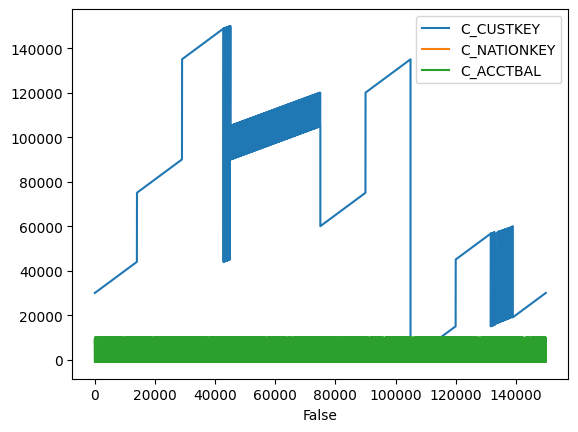

In [15]:
df_small_snow.plot(x='C_CUSTKEY', y='C_NATIONKEY')

In [16]:
df_small_snow.get_backend() # should be pandas

'Pandas'